## Path sampling

This notebook contains the code for Qijia's path sampling idea.

First, imports:

In [1]:
import jax
import jax.numpy as jnp
from nn import MLP, train
import numpy as np
import matplotlib.pyplot as plt
import optax 
import scipy
import os
from functools import partial


`batch_size` is the number of paths (that we use each time we update the drift)

`ndims` is the number of dimensions of the problem. Here we work with a TPS example, of a double well in 2D.

In [2]:
# this allows for parallelization with pmap. Not currently used
os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count=" + str(200)

# currently we're just doing an SDE on \mathbb{R}
ndims = 2


We now define a function that generates random paths given a drift term `b` and a noise term `W`:

## 2D double well example

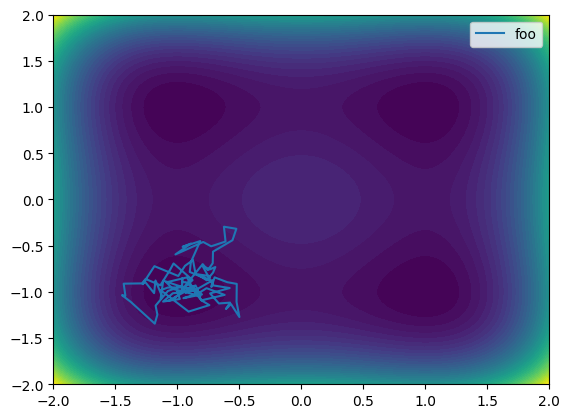

In [3]:
from path_sampling import sample_sde


def make_double_well_potential_2D(v):
    def potential(x):
        # print(x.shape, "x shape")
        # return None
        """
        Double well potential
        """
    
        if x.shape != (2,):
            print(f"Expected shape (2,), got {x.shape}")
        assert x.shape == (2,)
        return jnp.sum(v*(x**2 - 1)**2, axis=-1)
    return potential

make_double_well_potential_2D(v=1.0)(jnp.array([0.5, 0.5]))

def uref_2d(x,t):
    return -jax.grad(make_double_well_potential_2D(v=1.0))(x)

path, time = sample_sde(
    b=uref_2d,
    W=lambda x, key: jax.random.normal(key, shape=(2,)),
    rho=lambda key: jnp.zeros((2,))-1,
    dt=0.01,
    num_steps=100,
    key=jax.random.PRNGKey(0)
)

def plot_path(path, potential, label):

    # plot path in 2D
    plt.plot(path[:, 0], path[:, 1], label=label)
    plt.legend()
    
    
    # plot heatmap of the potential make_double_well_potential
    v = 1.0
    x = np.linspace(-2, 2, 100)
    y = np.linspace(-2, 2, 100)
    X, Y = np.meshgrid(x, y)
    # print(X.shape)
    # use vmap to apply the potential to the grid
    Z = jax.vmap(lambda x,y: potential(jnp.array([x,y])))(X.reshape(-1), Y.reshape(-1)).reshape(X.shape)
    plt.contourf(X, Y, Z, levels=50)

plot_path(path, make_double_well_potential_2D(1.0), label="foo")


We can then calculate a path cost `J(x)` as follows:

In [11]:
# import itertools

# from path_sampling import E_J, make_h_loss


# def find_dbds(dbds, J, s, b, xs, times, ys, num_training_steps):
#     """
#     model_key: random key for the model
#     expectation_of_J: the expectation of J, computed from the paths
#     b: drift term. A function from R^ndims x R -> R^ndims
#     xs: array of shape [batch_size, num_steps, ndims]
#     times: array of shape [batch_size, num_steps]
#     ys: for current purposes, just None
#     num_training_steps: number of training steps to take
#     Returns:
#         dbds: the trained model, which is a function from R^ndims x R -> R^ndims
#     """

#     expectation_of_J = E_J(J, xs, ys)

#     # print(s, "s")

#     # dbds = MLP([3,20,20,1], key=model_key) # create an NN, with random weights
#     learning_rate = 1e-3
#     optimizer = optax.adam(learning_rate)
#     h_loss = make_h_loss(expectation_of_J, J, b, s)
#     dbds = train(h_loss, dbds, optimizer, num_training_steps, xs, times, ys)
#     return dbds

# def make_b(schedule, uref, dbds):

#     schedule_padded = np.concatenate([np.zeros((1,)), np.array(schedule)])

#     # dss = np.concatenate([np.array([schedule[0]]), np.array(schedule)[1:] - np.array(schedule)[:-1]])
#     dss = np.array(schedule_padded)[1:] - np.array(schedule_padded)[:-1]

#     print(dss)


#     print(list(zip(schedule, dss)), "schedule")

#     b = lambda x, t: (uref(x,t) + sum([ds*dbds(x,t,s) for (s,ds) in zip(schedule, dss)]))

#     return b 

# # b \mapsto b + dbds
# # Pseudo code:
# # create `xs` of shape [batch_size, num_steps, ndims]
# # calculate expectation of J
# # initialize a neural net as function from R^ndims x R -> R^ndims
# # fit weights of neural net according to the loss function
# # calculate test loss
# # return lambda x: b(x) + dbds(x)
# def update(b, J, dbds, hyperparams, key, schedule, i, rho = lambda key: jnp.zeros((ndims,))-1.):
#     """
#     b: drift term. A function from R^ndims x R -> R^ndims
#     hyperparams: dictionary of hyperparameters
#     key: random key for the model
#     i: index for the current iteration (just for labelling plots)
#     Returns:
#         new_b: the updated drift term, which is a function from R^ndims x R -> R^ndims
#     """

#     new_s = schedule[i]
#     old_s = schedule[i-1] if i>0 else 0.0
#     ds = new_s - old_s

#     # b = make_b(schedule[:i], uref, dbds)

#     path_key, model_key, refine_key = jax.random.split(key, 3)

#     W = lambda _, key: jnp.sqrt(2)*jax.random.normal(key, shape=(ndims,))
    

#     # xs : [batch_size, num_steps, ndims]
#     xs, times = jax.pmap(lambda key:sample_sde(
#     b=b, 
#     W = W,
#     rho = rho,
#     key=key, 
#     dt=hyperparams['dt'], 
#     num_steps=hyperparams['num_steps']))(jax.random.split(path_key, hyperparams['batch_size']))

#     time = np.arange(0,hyperparams['num_steps'])*hyperparams['dt']
    
#     print("old s", old_s)

#     # path refinement
#     def logdensity_fn(x):
#         x = x.reshape((hyperparams['num_steps'], ndims))
#         # print(x.shape, time.shape, "foobar")
#         I_term = I(x, time, uref_2d)
#         J_term = J(x, None)
#         # J_term = jnp.linalg.norm(x[-1] - rho(jax.random.key(0)), ord=2)**2
#         # init_term = jnp.linalg.norm(x[1] - rho(jax.random.key(0)))**2
#         return -I_term - 1.0* J_term
    
#     # new_xs = jax.pmap(lambda key, p: refine_path(
#     #     x=p,
#     #     # s=old_s,
#     #     logdensity_fn=logdensity_fn,
#     #     # time=time,
#     #     rng_key=key,
#     #     num_steps=1000
#     #     ))(jax.random.split(refine_key, hyperparams['batch_size']), xs)[:,:, None]
    
#     # new_xs = new_xs.reshape((hyperparams['batch_size'], hyperparams['num_steps'], ndims))

#     # print(E_J(xs, None), "ej x")
#     # print(E_J(new_xs, None), "ej new x")
#     # print(times)

#     # for path in xs:
#     #     plt.plot(path,(time/hyperparams['dt'])/10, label='old')
#     # for path in new_xs:
#     #     plot_path(path, make_double_well_potential_2D(v=1.0), label=f'annealed')
#         # plt.plot(path,(time/hyperparams['dt'])/5, label=f'annealed')

#     # xs = jnp.concatenate((xs[:10, :, :], new_xs[:30, :, :]), axis=0)
#     # xs = new_xs

#     # print("shapes", new_xs.shape, xs.shape)

#     expectation_of_J = E_J(J, xs, None)

#     dbds = find_dbds(
#         dbds=dbds,
#         J=J,
#         s=new_s,
#         b=b,
#         # xs[:90, :, :],
#         # times[:90, :],
#         xs=xs,
#         times=times,
#         ys=None,
#         num_training_steps=hyperparams['num_training_steps']
#         )
    
#     ### calculate test loss
#     test_xs, test_times = jax.pmap(lambda key:sample_sde(
#         b=b, 
#         W = W,
#         rho = rho,
#         key=key, 
#         dt=hyperparams['dt'], 
#         num_steps=hyperparams['num_steps']))(jax.random.split(jax.random.key(500), hyperparams['batch_size']))

#     print(f"Test loss is {make_h_loss(expectation_of_J=expectation_of_J, J=J, b=b, s=new_s)(dbds, test_xs, test_times, None)}")

#     # new version
#     # new+b = b + [dbds(x,t,s)*delta_s for s in ...]

#     # print(ds, "ds")
    
#     new_b =  lambda x, t: (b(x,t) + dbds(x,t, 0.0)*ds)

#     # new_b =  lambda x, t: (b(x,t) + dbds(x,t, new_s))

#     # new_b = make_b(schedule[:i+1], uref, dbds)

#     plot = True
#     if plot:

#         # x = jnp.expand_dims(jnp.linspace(-2, 2, 100), 1)
#         # # y = (x**4 - 8 * x**2)
#         # y = make_double_well_potential_2D(v=1.0)(x)
#         # y2 = jax.vmap(lambda k, t: new_b(k, t))(x, times[0])
#         # plt.ylim(0,15)
#         # if i==0: plt.plot(x, y)
#         # plt.plot(x, y2/50)
#         # print(y2)


#         path, time = sample_sde(
#             b=new_b, 
#             W = W,
#             rho = rho,
#             key=key, 
#             dt=hyperparams['dt'], 
#             num_steps=hyperparams['num_steps'])
                
#         # refined_path = refine_path(
#         #     x=path,
#         #     s=new_s,
#         #     time=time,
#         #     rng_key=jax.random.key(2),
#         #     num_steps=1000
#         #     )
#         label = f"{i}"
#         plot_path(path, make_double_well_potential_2D(v=1.0), label)

#         # print("OM of path", I(path, time, uref))
#         # print("OM of refined path", I(refined_path, time, uref))

#         # plt.plot(path,(time/hyperparams['dt'])/10, label=i)
#         # plt.plot(refined_path,(time/hyperparams['dt'])/10, label=f'refined_{i}')
#         # plt.savefig('potential_new.png')
#         plt.legend()

#     return new_b


In [128]:
# uref_2d(jnp.array([0.5, 0.5]), 0.5)
# dbds = MLP([6,20,20,2], key=jax.random.key(0))
# dbds(jnp.array([0.5, 0.5]), 0.5, 0.5)

# make_h(
#     b=uref_2d,
#     dbds=dbds,
#     s=0.5
# )(jnp.ones((3, 2)), jnp.ones((3)))

x div shape (3, 2)
time div shape (3,)
easy (2,)
(2, 2)


Array(-0.00644326, dtype=float32)

AssertionError: 

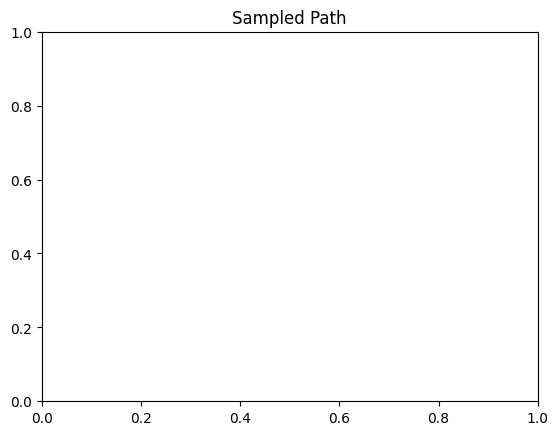

In [6]:
from path_sampling import dfdt, div_f, update


key = jax.random.key(0)
# b = uref # initialize b as uref
# schedule = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0] # , 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
# schedule = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0] # , 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
schedule = [0.1] # , 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
dbds = MLP([6,20,20,2], key=jax.random.key(0))

def I_UREF_TPS(x, time, uref):
    x = x.reshape((-1, ndims))
    dt = time[1]-time[0]
    dxdts = dfdt(x, dt)
    div_us = div_f(x, time, uref)
    out = jax.vmap(lambda xt,t, div_u, dxdt : 0.5*dt*(0.5*(dxdt - uref(xt, t)).dot(dxdt - uref(xt, t)) + 0.5*div_u)) (x, time, div_us, dxdts)
    return jnp.sum(out)  

b = uref_2d
A = 0
plt.figure()
plt.title("Sampled Path")
for i, s in enumerate(schedule):



    key = jax.random.fold_in(key, i)

    # update b -> b + dbds
    dbds, A = update(
        uref=b, # lambda x, t : jnp.array([0.0]),
        J=(lambda x, y: (1/0.1**2)*jnp.linalg.norm(x[-1]- np.array([1,1]))**2),
        # J=(lambda x, y: (1/0.1**2)*(jnp.linalg.norm(x[-1]- np.array([1,1]))**2 + jnp.linalg.norm(x[50]- np.array([1,-1]))**2) ) ,
        dbds=dbds,
        hyperparams={'dt': 0.001, 'num_steps': 100, 'num_training_steps' : 1000, 'batch_size' :200},
        key=key,
        schedule=schedule,
        i=i,
        I=I_UREF_TPS,
        A=A,
    )

# potential(jnp.array([0.0]))

# jax.grad(lambda x:jnp.sum(x**2))(jnp.array([4.0]))
# uref(jnp.array([0.0]), 0.0)

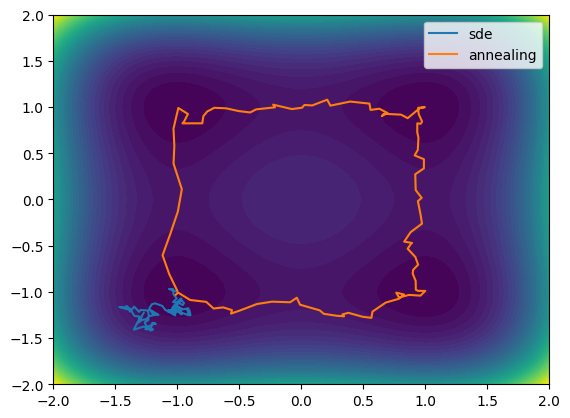

In [16]:
from mclmc import run_mclmc
from path_sampling import dfdt, div_f


path_key = jax.random.key(0)
hyperparams = {'dt': 0.001, 'num_steps': 100, 'num_training_steps' : 5000, 'batch_size' :200}
xs, times = jax.pmap(lambda key:sample_sde(
    b=lambda x,t: 0.0,
    W = lambda _, key: jax.random.normal(key, shape=(ndims,)),
    # rho = lambda key: jax.random.normal(key, shape=(ndims,))-2,
    rho = lambda key: jnp.zeros((ndims,))-1.,
    key=key, 
    dt=hyperparams['dt'], 
    num_steps=hyperparams['num_steps']))(jax.random.split(path_key, 1))


initial_position = xs[0].reshape(xs[0].shape[0]*xs[0].shape[1])

time = times[0]

def I(x, time, uref):
    x = x.reshape((-1, ndims))
    dt = time[1]
    dxdts = dfdt(x, dt)
    div_us = div_f(x, time, uref)
    out = jax.vmap(lambda xt,t, div_u, dxdt : 0.5*dt*(0.5*(dxdt - uref(xt, t)).dot(dxdt - uref(xt, t)) + 0.5*div_u)) (x, time, div_us, dxdts)
    return jnp.sum(out)


s = 1.0
def logdensity_fn(x):
    x = x.reshape((hyperparams['num_steps'], ndims))
    # print(x.shape, time.shape, "foobar")
    I_term = I(x, time, uref_2d)
    J_term = (1/0.01**2)*(
        jnp.linalg.norm(x[-1]- np.array([-1,-1]))**2 
        + jnp.linalg.norm(x[30]- np.array([1,-1]))**2
        + jnp.linalg.norm(x[60]- np.array([1,1]))**2
        + jnp.linalg.norm(x[90]- np.array([-1,1]))**2
        + jnp.linalg.norm(x[1]- np.array([-1,-1]))**2
        # + jnp.linalg.norm(x[0]- np.array([-1,-1]))**2
        
        )
    # init_term = (1)*jnp.linalg.norm(x[0]- np.array([-1,-1]))**2
    # jax.debug.print("int {x}",x=jnp.linalg.norm(x[1]- np.array([-1,-1]))**2)

    return -I_term - s*J_term


    # logdensity_fn = lambda x: jax.scipy.stats.norm.logpdf(x[0], loc=-2, scale=0.01)- I(x, time, lambda x, t: uref(-x,t)) - s*J(x.reshape((-1, ndims)), None)
    # logdensity_fn = lambda x: jax.scipy.stats.norm.logpdf(x[0], loc=-1, scale=0.01)- I(x, time, lambda x, t: uref(x,t)) - s*J(x.reshape((-1, ndims)), None)

    # logdensity_fn = lambda x: I(x, time, uref) 


samples, _, params, chain_key = run_mclmc(
    logdensity_fn=logdensity_fn,
    num_steps=1000,
    initial_position=initial_position,
    key=jax.random.key(0),
    transform=lambda state, info: state.position
)

samples = samples[-1].reshape((hyperparams['num_steps'], ndims))

# print(samples.shape, "samples shape")
plot_path(xs[0], make_double_well_potential_2D(v=1.0), label="sde")
plot_path(samples, make_double_well_potential_2D(v=1.0), label="annealing")
# print(samples)


## Brownian sanity check